# Mixtec Gender Classification

### Imports

In [1]:
%matplotlib inline

import torch
from  torch.utils.data import random_split
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Define hardware

In [2]:
device = torch.device("cpu")

### Define path to images

In [3]:
path = '../data/labeled_figures/codex_vindobonensis/gender/'

### Load figures into dataset

In [4]:
## Load CSV
mixtec_figures = pd.read_csv("../data/mixtec_figures.csv")

print(mixtec_figures['gender'].value_counts())

## Define image transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((227, 227)),
    transforms.Grayscale()])

## Load images into PyTorch dataset
figures_dataset = datasets.ImageFolder(path, transform=transform)

print(figures_dataset)

male      429
female     45
Name: gender, dtype: int64
Dataset ImageFolder
    Number of datapoints: 210
    Root location: ../data/labeled_figures/codex_vindobonensis/gender/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
           )


### Assign classes to map

In [5]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

/Users/alex/miniconda3/envs/mixtec/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


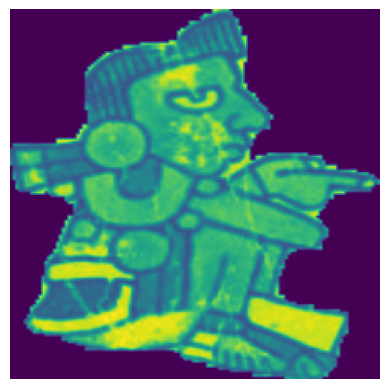

In [6]:
# Access a random image from the dataset
random_index = np.random.randint(len(figures_dataset))
image, label = figures_dataset[random_index]

# Convert the image tensor to a NumPy array and transpose it
image = image.permute(1, 2, 0)
image = image.numpy()

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Split datasets into training and testing sets

In [7]:
batch_size = 20

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

# Training

### Define CNN

In [8]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x



# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Define hyperparameters

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### Train model

In [10]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0

print('Finished Training')


Epoch: 1 | Loss: 8.048322677612305
Epoch: 2 | Loss: 4.123405933380127
Epoch: 3 | Loss: 0.5357621908187866
Epoch: 4 | Loss: 0.8880912065505981
Epoch: 5 | Loss: 0.6769490838050842
Epoch: 6 | Loss: 0.47599315643310547
Epoch: 7 | Loss: 0.46319469809532166
Epoch: 8 | Loss: 0.3046077787876129
Epoch: 9 | Loss: 0.3298855125904083
Epoch: 10 | Loss: 0.3834543824195862
Finished Training


### View incorrectly labeled samples

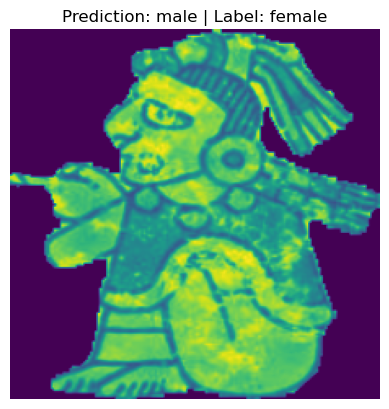

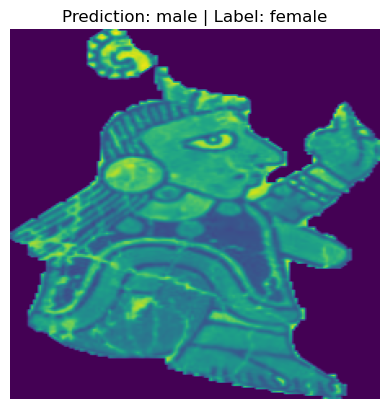

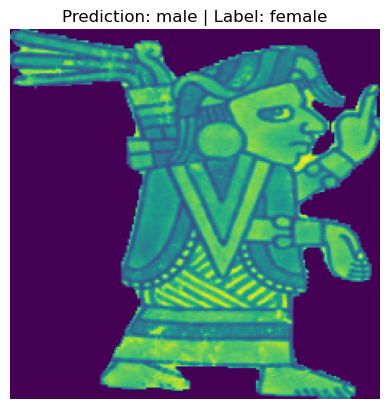

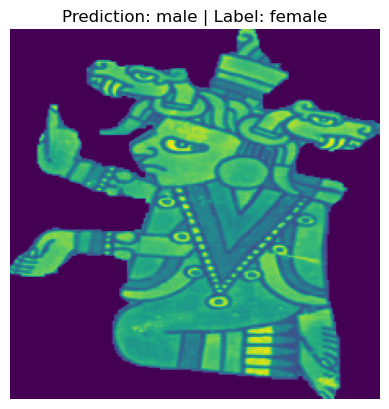

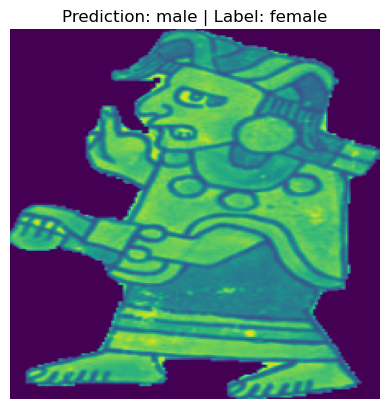

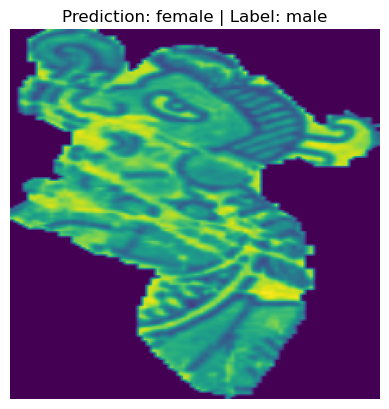

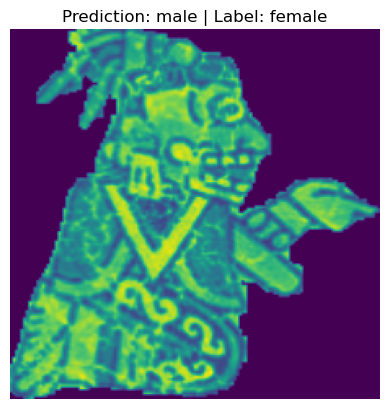

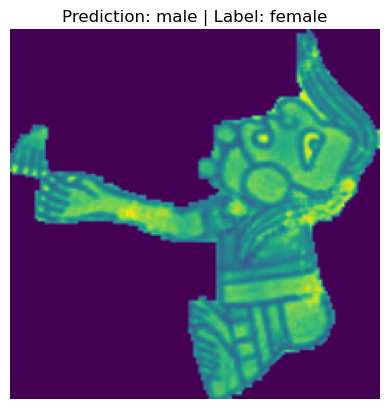

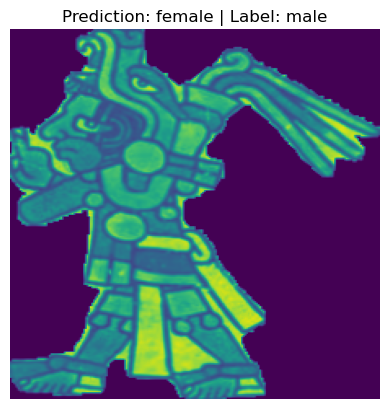

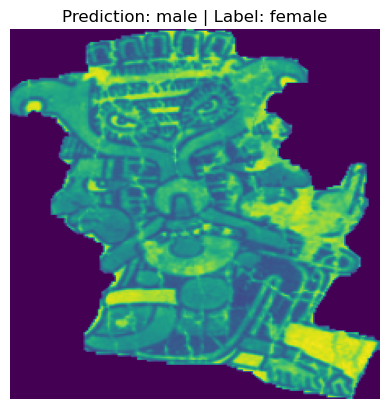

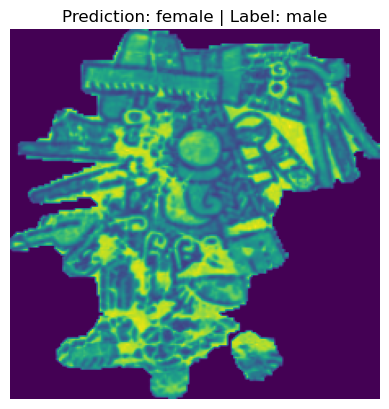

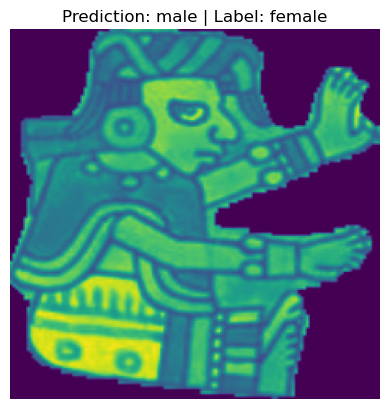

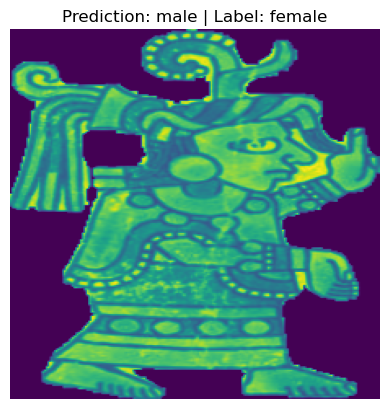

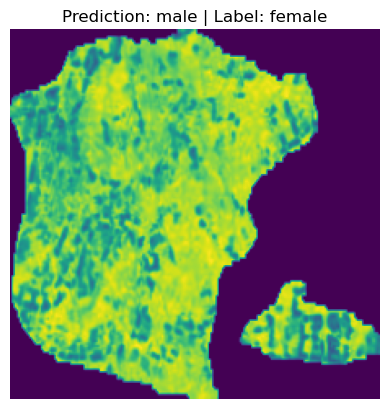

In [11]:
for i, data in enumerate(train_loader, 0):
    images, labels = data
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [12]:
PATH = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), PATH)

### Visualize learning

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [14]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

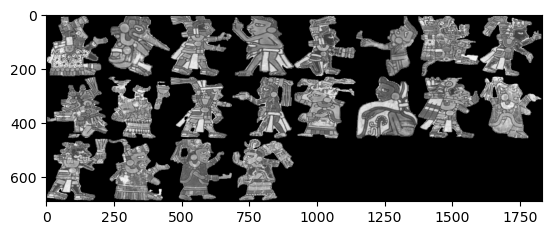

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [16]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [17]:
cnn = CNN()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Produce predictions and calculate accuracy of model

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

Accuracy of the network on the 42 test images: 85 %
